<h1>RL For waste collection</h1>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import random

In [ ]:
from google.colab import drive
 
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/Project
# ISOT_real = pd.read_csv('ISOT_True.csv')')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Project


In [ ]:
position = pd.read_csv('dlrrefusebinslocations.csv',encoding='latin1')


# assigning random values for weight of waste in the bin
weights = (np.random.choice(range(0,300), size=len(position), replace=True))/10
position['weight']=weights

#The depot coordinates are stored in the CSV file. Coordinates obtained from Google 
depot = pd.read_csv('Depot.csv',encoding='latin1')

position= position.append(depot, ignore_index=True)

my_df = position.sort_values(by=['Bin no.'],ignore_index=True)
my_df

,Description,Latitude,Longitude,Bin no.,weight
0,DLR Depot,53.288725,-6.125561,0,0.0
1,"AA - 1 - Foxrock Park, opposite 28",53.276056,-6.171494,1,18.3
2,"AB - 2 - Foxrock Ave, beside lane opposite 59a...",53.277844,-6.174038,2,21.3
3,"AC - 3 - Foxrock Ave, outside shops",53.277888,-6.173128,3,23.8
4,"AD - 4 - Kill Lane, outside Deansgrange library",53.277792,-6.164915,4,26.1
...,...,...,...,...,...
394,"OTA - 395 - Bird Avenue, green area on front o...",53.305363,-6.237037,395,18.4
395,"KFA - 396 - St. Raphaels Road, at bus stop bes...",53.280162,-6.210452,396,14.7
396,"MVA - 397 - Chruchtown Road, at Luas bridge",53.293747,-6.247656,397,28.1
397,"HKA - 398 - Arnold Park, at entrance to park",53.271281,-6.130891,398,8.5


In [ ]:
my_df=my_df.head(n=31)
LEN=(len(my_df))
print(LEN)

31


In [ ]:
sum(my_df['weight'])

553.5999999999999

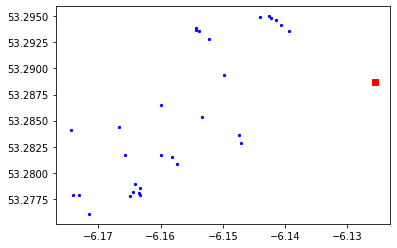

In [ ]:
#Roughly displaying the location of all the bins(blue) and depot (red) 
plt.plot(my_df['Longitude'][0], my_df['Latitude'][0], c='r', marker='s')
plt.scatter(my_df['Longitude'][1:], my_df['Latitude'][1:], c='b',s=5)

In [ ]:
distance= np.zeros(len(my_df)*len(my_df)).reshape(len(my_df), len(my_df))

In [ ]:
R = 6373.0 # approximate radius of earth in km
for i in range (0,len(my_df)):
    for j in range(0,len(my_df)):
        if i == j:
            distance[i,j]=float('inf')
        else : 
            lat1 = radians(my_df["Latitude"][i])
            lon1 = radians(my_df["Longitude"][i])
            lat2 = radians(my_df["Latitude"][j])
            lon2 = radians(my_df["Longitude"][j])
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            distance[i,j] = round(R * c ,4)
#             print("\n")


In [ ]:

print(f"Shape of the distance matrix is: {distance.shape}")


Shape of the distance matrix is: (31, 31)


In [ ]:
def prepPlot(FINAL_ROUTE):
    i=0
    d={}
    d1={}
    for key in FINAL_ROUTE:
        x=[]
        y=[]
        var1='x'+str(key)
        var2='y'+str(key)
        d1[key]=list([var1,var2])
        listed= FINAL_ROUTE[key]
        for i in listed:
            x.append(my_df.iloc[i]['Latitude'])
            y.append(my_df.iloc[i]['Longitude'])
        d[var1]=x
        d[var2]=y
    return d
#          y.append(my_df[my_df['Bin no.']==i]['Longitude'].values[0])


In [ ]:
def makemap(d):
    from matplotlib.pyplot import figure

    figure(figsize=(8, 6), dpi=80)
    for i in range(int((len(d))/2)):
        var1='y'+str(i)
        var2='x'+str(i)
        label1='Agent '+str(i)
        plt.plot(d[var1],d[var2], label=label1)
    
    
    plt.scatter(my_df['Longitude'][1:], my_df['Latitude'][1:], c='g',s=10,label='Bin')
    plt.scatter(my_df['Longitude'][0], my_df['Latitude'][0], c='r',marker='s', label='Depot')

    plt.legend(loc='upper right');   
    if(int(len(d)/2) == 1):
        plt.title("DLR Refuse Bins for single agent")
    else:
        plt.title("DLR Refuse Bins for mutiple agents")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


In [ ]:
depo_capacity=0
depot_node=0
bins_left=len(my_df)-1
truck_cap=700
weight = pd.Series(list(my_df['weight']))
FINAL_ROUTE={}
DIST_TOTAL={}
city_waste=sum(my_df['weight'])

In [ ]:
depo_capacity=0
DEPOT_NODE=0
bins_left=len(my_df)-1
TRUCK_CAP=700
ITERATION_NUMBER=0
weight = pd.Series(list(my_df['weight']))
DF_LEN = len(distance)

In [ ]:
class Environment():
    def __init__(self,curr_node=DEPOT_NODE):
        self.curr_node=0
        self.isEnd = 0 
        self.StateSpace = pd.DataFrame()
        self.weight=pd.Series(list(my_df['weight']))
        self.distance=distance
        self.prev_node=0
        
    def getReward(self,node,capacity,distance_covered):
        if self.curr_node == DEPOT_NODE:
            if capacity >= 0.9*TRUCK_CAP:
                return 200
            elif sum(self.weight) < 0.00001: # to avoid issues with floating point comparison
                return 100
            else:
                return -500
        else:
            if capacity == self.prev_capacity or self.curr_node == self.prev_node:
                temp_reward=-100
            else:
                temp_reward=100
            return (capacity*10 - (distance_covered )+ temp_reward)/100

    def isEndFunc(self,capacity):
        if (sum(self.weight)==0):
        # if (self.curr_node == DEPOT_NODE and (capacity >= TRUCK_CAP or sum(self.weight)== 0)):
            # print(f"Unloading {round(capacity,2)} kg of waste at depot")
            self.isEnd = 1
            # print(self.isEnd)
        # return (self.isEnd)



    def update_statespace(self, new_node):   #,agent_id):
        A= self.distance[new_node][:]
        self.near_nodes=list(np.argsort(A))
        self.near_node_dist=list(self.distance[new_node][self.near_nodes])
        self.near_node_weight=list(self.weight[self.near_nodes])
        self.StateSpace=pd.DataFrame(list(zip(self.near_nodes,self.near_node_dist,self.near_node_weight)),
                             columns = ['Node','Distance', 'Weight'])

        if self.StateSpace.empty:
            print('DataFrame is empty!')
        return (self.StateSpace)   
    
    def next_position(self,node,action,capacity):   # To add update weight  
        StateSpace=self.update_statespace(node)
        dist=0
        if action in range(1,LEN) :
            self.prev_node = node
            self.curr_node = StateSpace['Node'].iloc[action]
            self.prev_capacity=capacity
            capacity = StateSpace[StateSpace['Node']==self.curr_node]['Weight'].values[0]
            self.weight[self.curr_node]=0
            dist = StateSpace[StateSpace['Node']==self.curr_node]['Distance'].values[0]
                
        elif action == 0 :
            self.curr_node = DEPOT_NODE
            capacity=0
            dist=StateSpace[StateSpace['Node']==DEPOT_NODE]['Distance'].values[0]
            self.isEndFunc(capacity)
        else:
            print(f"In error state Value of action is {action}")
        StateSpace = self.update_statespace(self.curr_node)
        if (dist == float('inf')):
              dist=0
        return self.curr_node,capacity,dist

In [ ]:
class AgentRL():
    def __init__(self):

        self.actions = list(range(0,LEN))    
        self.alpha = 0.5
        self.gamma = 0.9
        self.epsilon = 0.7
        self.plot_reward = []
        self.Q = {}
        self.new_Q = {}
        self.reward=0
        self.final_reward=0
        for i in range(DF_LEN):
            for k in range(len(self.actions)):  # initialising a 398 x 6 matrix
                self.Q[(i,k)] =0
                self.new_Q[(i, k)] = 0
    def ResetParams(self):
        self.route_list=[0]
        self.capacity=0
        self.isEnd=0
        self.distance_covered=0
        self.curr_node=0
        self.reward=0
      #self.env=Environment()
    def showValues(self):
        for i in range(0, DF_LEN):
            out = '| '
            mx_nxt_value = -10
            for a in self.actions:
                nxt_value = self.Q[(i,a)]
                if nxt_value >= mx_nxt_value:
                    mx_nxt_value = nxt_value
            out += str(mx_nxt_value).ljust(6) + ' | '
#         print(out)

    def plot(self,routelist_len):
        
        plt.plot(routelist_len)
        plt.show()

    def Action(self,env):
        rnd = random.random()
        mx_nxt_reward =-100
        action = None
        if self.capacity >= 0.9* TRUCK_CAP or self.isEnd:
          action = 0
        elif (self.epsilon > rnd) :
            #iterate through actions, find Q  value and choose best 
            for k in self.actions:
                
                i = env.curr_node
                
                nxt_reward = self.Q[(i, k)]
                
                if nxt_reward >= mx_nxt_reward:
                    action = k
                    mx_nxt_reward = nxt_reward
                    # print(f"mx_nxt_reward = {mx_nxt_reward} for i={i} and k={k}")
        else:
            dummylist=self.actions[:]
            dummylist.remove(0)

            action = np.random.choice(dummylist)
  
        self.curr_node,self.cap_new,self.dist = env.next_position(self.curr_node,action,self.capacity)
        self.capacity += self.cap_new
        self.distance_covered +=self.dist
        self.route_list.append(self.curr_node)
        global ITERATION_NUMBER
        ITERATION_NUMBER +=1
        # print(f"-------------Iteration is {ITERATION_NUMBER}\n Value of Action is {action}")
        return self.curr_node,action

        
    def Q_Learning(self,env,epsilon,agentId):
        self.epsilon=epsilon
        capacity = self.capacity
        self.agentId=agentId

        
        env.isEndFunc(self.capacity)
        # print(f"is end is {env.isEnd}")
        if (env.isEnd==1):
            # print("in self.isEnd loop")
            reward = env.getReward(self.curr_node,self.cap_new,self.dist)
            self.reward += reward
            self.final_reward=self.reward
            # print(f"reward is {self.final_reward}")
            env.isEnd=-1
            # self.ResetParams()
            self.route_list.append(DEPOT_NODE)
            self.Q = self.new_Q.copy()
            
            
        else:
            # print("in else loop")
            mx_nxt_value = -10
            next_node, action = self.Action(env)
            i = next_node
            reward = env.getReward(self.curr_node,self.cap_new,self.dist)
            self.reward +=reward
            # print(f"value of reward is {self.reward}")
            for a in self.actions:
                nxtEnvironmentAction = (next_node, a)
                q_value = (1-self.alpha)*self.Q[(i,action)] + self.alpha*(reward + self.gamma*self.Q[nxtEnvironmentAction])
                if q_value >= mx_nxt_value:
                    mx_nxt_value = q_value
            env.isEndFunc(self.capacity)
            self.isEnd = env.isEnd
            self.new_Q[(i,action)] = round(mx_nxt_value,3)
            self.Q = self.new_Q.copy()
            # return self.route_list,self.distance_covered
        # self.Q = self.new_Q.copy()
        # print(mx_nxt_value)
        # print(f"Distance covered is {self.distance_covered}")
        return self.route_list,self.distance_covered


In [ ]:
episodes = 1000
epsilon =0.8

**Running Multi-agent RL system**


**2 Agents**

-------------0--------------
-------------1--------------
-------------2--------------
-------------3--------------
-------------4--------------
-------------5--------------
-------------6--------------
-------------7--------------
-------------8--------------
-------------9--------------
-------------10--------------
-------------11--------------
-------------12--------------
-------------13--------------
-------------14--------------
-------------15--------------
-------------16--------------
-------------17--------------
-------------18--------------
-------------19--------------
-------------20--------------
-------------21--------------
-------------22--------------
-------------23--------------
-------------24--------------
-------------25--------------
-------------26--------------
-------------27--------------
-------------28--------------
-------------29--------------
-------------30--------------
-------------31--------------
-------------32--------------
-------------33-----

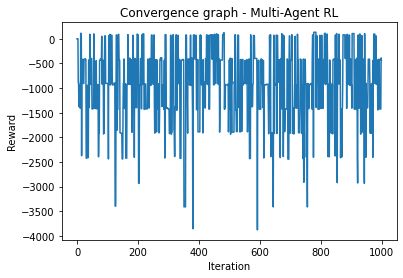

In [ ]:

if __name__ == "__main__":
    # episodes=100
    i=0
    
    ag=AgentRL()
    
    ag.ResetParams()
    ag2=AgentRL()
    ag2.ResetParams()
    env=Environment()
    IsEnd=False  

    epsilon=0.8
    
    FINAL_1={}
    FINAL_2={}

    DIST_TOTAL={}
    routelist={}
    routelist0={}
    routelist1={}

    routelist_len=[]
    dist0_cov=[]
    dist1_cov=[]
    mean_dist=[]
    plot_reward=[]
    plot_reward2=[]
    while (i<episodes):
        epsilon = 0.95*epsilon
        print(f"-------------{i}--------------")
        
        env=Environment()
        ag.ResetParams()
        ag2.ResetParams()
        env.weight=pd.Series(list(my_df['weight']))
        env.IsEnd=0  
        while (env.isEnd != -1):
            routelist0[i],dist0_covered=ag.Q_Learning(env,epsilon,0)
            routelist1[i],dist1_covered=ag2.Q_Learning(env,epsilon,1)
        
        meandist=(dist0_covered+dist1_covered)/2
        dist0_cov.append(dist0_covered)
        dist1_cov.append(dist1_covered)
        mean_dist.append(meandist)
        routelist_len.append(len(routelist0[0]))
        i +=1
        plot_reward.append(ag.final_reward)
        plot_reward2.append(ag2.final_reward)
    min_route=routelist_len.index(min(routelist_len))
    min_route=dist0_cov.index(min(dist0_cov))
    routelist[0]=routelist0[min_route]
    routelist[1]=routelist1[min_route]
    # plt.plot(dist0_cov)
    # plt.plot(dist1_cov)
    #plt.plot(mean_dist)
    plt.title("Convergence graph - Multi-Agent RL")
    plt.xlabel("Iteration")
    plt.ylabel("Reward")
    

    plt.plot(plot_reward)  
    # plt.plot(plot_reward2)


Text(0, 0.5, 'Distance covered')

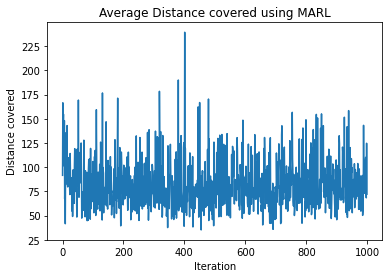

In [ ]:
plt.plot(mean_dist)
plt.title("Average Distance covered using MARL")
plt.xlabel("Iteration")
plt.ylabel("Distance covered")

In [ ]:
d2=prepPlot(routelist)
d2.keys()
# d3=prepPlot(routelist)
# d3.keys()

dict_keys(['x0', 'y0', 'x1', 'y1'])

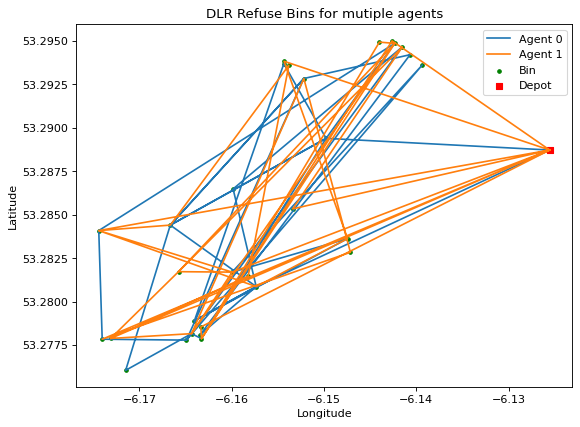

In [ ]:
makemap(d2)

In [ ]:
print(f"Minimum distance learnt by 2 Agents in a Multi-Agent Reinforcement learning environment is {min(mean_dist)} km ")

Minimum distance learnt by 2 Agents in a Multi-Agent Reinforcement learning environment is 35.1744 km 


**4 Agents**

-------------0--------------
-------------1--------------
-------------2--------------
-------------3--------------
-------------4--------------
-------------5--------------
-------------6--------------
-------------7--------------
-------------8--------------
-------------9--------------
-------------10--------------
-------------11--------------
-------------12--------------
-------------13--------------
-------------14--------------
-------------15--------------
-------------16--------------
-------------17--------------
-------------18--------------
-------------19--------------
-------------20--------------
-------------21--------------
-------------22--------------
-------------23--------------
-------------24--------------
-------------25--------------
-------------26--------------
-------------27--------------
-------------28--------------
-------------29--------------
-------------30--------------
-------------31--------------
-------------32--------------
-------------33-----

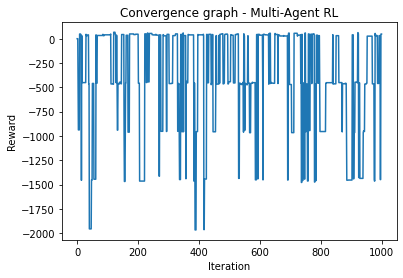

In [ ]:

if __name__ == "__main__":
    # episodes=100
    i=0
    for x in range(0, 4):
      globals()['Agent%s' % x] = AgentRL()
    # ag=AgentRL()
    
    Agent0.ResetParams()
    Agent1.ResetParams()
    Agent2.ResetParams()
    Agent3.ResetParams()
    env=Environment()
    IsEnd=False  

    epsilon=0.8
    
    FINAL_0={}
    FINAL_1={}
    FINAL_2={}
    FINAL_3={}

    DIST_TOTAL={}
    routelist={}
    routelist0={}
    routelist1={}
    routelist2={}
    routelist3={}

    routelist_len=[]
    dist0_cov=[]
    dist1_cov=[]
    dist2_cov=[]
    dist3_cov=[]
    
    mean_dist=[]
    plot_reward=[]
    plot_reward2=[]
    while (i<episodes):
        epsilon = 0.95*epsilon
        print(f"-------------{i}--------------")
        
        env=Environment()
        Agent0.ResetParams()
        Agent1.ResetParams()
        Agent2.ResetParams()
        Agent3.ResetParams()
        
        env.weight=pd.Series(list(my_df['weight']))
        env.IsEnd=0  
        while (env.isEnd != -1):
            routelist0[i],dist0_covered=Agent0.Q_Learning(env,epsilon,0)
            routelist1[i],dist1_covered=Agent1.Q_Learning(env,epsilon,1)
            routelist2[i],dist2_covered=Agent2.Q_Learning(env,epsilon,2)
            routelist3[i],dist3_covered=Agent3.Q_Learning(env,epsilon,3)
        
        meandist=(dist0_covered+dist1_covered+dist2_covered+dist3_covered)/4
        dist0_cov.append(dist0_covered)
        dist1_cov.append(dist1_covered)
        dist2_cov.append(dist2_covered)
        dist3_cov.append(dist3_covered)
        mean_dist.append(meandist)
        routelist_len.append(len(routelist0[0]))
        i +=1
        plot_reward.append(Agent0.final_reward)
        plot_reward2.append(ag2.final_reward)
    min_route=routelist_len.index(min(routelist_len))
    min_route=dist0_cov.index(min(dist0_cov))
    routelist[0]=routelist0[min_route]
    routelist[1]=routelist1[min_route]
    routelist[2]=routelist2[min_route]
    routelist[3]=routelist3[min_route]
    # plt.plot(dist0_cov)
    # plt.plot(dist1_cov)
    #plt.plot(mean_dist)
    plt.title("Convergence graph - Multi-Agent RL")
    plt.xlabel("Iteration")
    plt.ylabel("Reward")
    

    plt.plot(plot_reward)  
    # plt.plot(plot_reward2)


Text(0, 0.5, 'Distance covered')

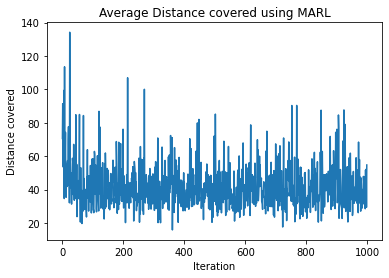

In [ ]:
plt.plot(mean_dist)
plt.title("Average Distance covered using MARL")
plt.xlabel("Iteration")
plt.ylabel("Distance covered")

In [ ]:
d2=prepPlot(routelist)
d2.keys()
# d3=prepPlot(routelist)
# d3.keys()

dict_keys(['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'])

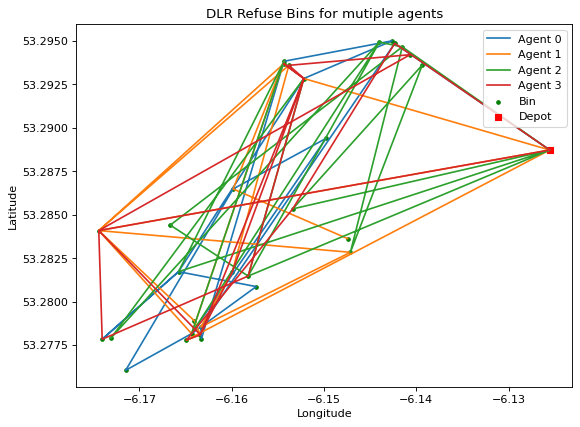

In [ ]:
makemap(d2)

In [ ]:
print(f"Minimum distance learnt by 4 Agents in a Multi-Agent Reinforcement learning environment is {min(mean_dist)} km ")

Minimum distance learnt by 2 Agents in a Multi-Agent Reinforcement learning environment is 15.826825 km 


**6 Agents**

-------------0--------------
-------------1--------------
-------------2--------------
-------------3--------------
-------------4--------------
-------------5--------------
-------------6--------------
-------------7--------------
-------------8--------------
-------------9--------------
-------------10--------------
-------------11--------------
-------------12--------------
-------------13--------------
-------------14--------------
-------------15--------------
-------------16--------------
-------------17--------------
-------------18--------------
-------------19--------------
-------------20--------------
-------------21--------------
-------------22--------------
-------------23--------------
-------------24--------------
-------------25--------------
-------------26--------------
-------------27--------------
-------------28--------------
-------------29--------------
-------------30--------------
-------------31--------------
-------------32--------------
-------------33-----

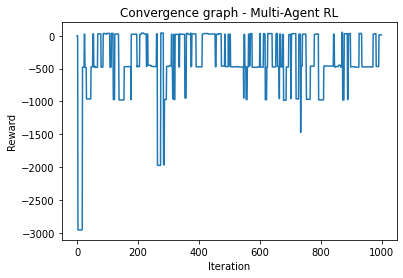

In [ ]:

if __name__ == "__main__":
    # episodes=100
    i=0
    for x in range(0, 6):
      globals()['Agent%s' % x] = AgentRL()
    # ag=AgentRL()
    
    Agent0.ResetParams()
    Agent1.ResetParams()
    Agent2.ResetParams()
    Agent3.ResetParams()
    Agent4.ResetParams()
    Agent5.ResetParams()
    env=Environment()
    IsEnd=False  

    epsilon=0.8
    
    FINAL_0={}
    FINAL_1={}
    FINAL_2={}
    FINAL_3={}
    FINAL_4={}
    FINAL_5={}
	
    DIST_TOTAL={}
    routelist={}
    routelist0={}
    routelist1={}
    routelist2={}
    routelist3={}
    routelist4={}
    routelist5={}

    routelist_len=[]
    dist0_cov=[]
    dist1_cov=[]
    dist2_cov=[]
    dist3_cov=[]
    dist4_cov=[]
    dist5_cov=[]
    
    mean_dist=[]
    plot_reward=[]
    plot_reward2=[]
    while (i<episodes):
        epsilon = 0.95*epsilon
        print(f"-------------{i}--------------")
        
        env=Environment()
        Agent0.ResetParams()
        Agent1.ResetParams()
        Agent2.ResetParams()
        Agent3.ResetParams()
        Agent4.ResetParams()
        Agent5.ResetParams()
        
        env.weight=pd.Series(list(my_df['weight']))
        env.IsEnd=0  
        while (env.isEnd != -1):
            routelist0[i],dist0_covered=Agent0.Q_Learning(env,epsilon,0)
            routelist1[i],dist1_covered=Agent1.Q_Learning(env,epsilon,1)
            routelist2[i],dist2_covered=Agent2.Q_Learning(env,epsilon,2)
            routelist3[i],dist3_covered=Agent3.Q_Learning(env,epsilon,3)
            routelist4[i],dist4_covered=Agent4.Q_Learning(env,epsilon,4)
            routelist5[i],dist5_covered=Agent5.Q_Learning(env,epsilon,5)
        
        meandist=(dist0_covered+dist1_covered+dist2_covered+dist3_covered+dist4_covered+dist5_covered)/6
        dist0_cov.append(dist0_covered)
        dist1_cov.append(dist1_covered)
        dist2_cov.append(dist2_covered)
        dist3_cov.append(dist3_covered)
        dist4_cov.append(dist4_covered)
        dist5_cov.append(dist5_covered)
        mean_dist.append(meandist)
        routelist_len.append(len(routelist0[0]))
        i +=1
        plot_reward.append(Agent0.final_reward)
    min_route=routelist_len.index(min(routelist_len))
    min_route=dist0_cov.index(min(dist0_cov))
    routelist[0]=routelist0[min_route]
    routelist[1]=routelist1[min_route]
    routelist[2]=routelist2[min_route]
    routelist[3]=routelist3[min_route]
    routelist[4]=routelist4[min_route]
    routelist[5]=routelist5[min_route]
    # plt.plot(dist0_cov)
    # plt.plot(dist1_cov)
    #plt.plot(mean_dist)
    plt.title("Convergence graph - Multi-Agent RL")
    plt.xlabel("Iteration")
    plt.ylabel("Reward")
    

    plt.plot(plot_reward)  
    # plt.plot(plot_reward2)


Text(0, 0.5, 'Distance covered')

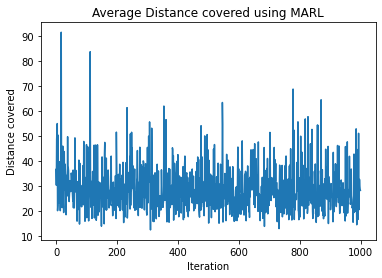

In [ ]:
plt.plot(mean_dist)
plt.title("Average Distance covered using MARL")
plt.xlabel("Iteration")
plt.ylabel("Distance covered")

In [ ]:
d2=prepPlot(routelist)
d2.keys()
# d3=prepPlot(routelist)
# d3.keys()

dict_keys(['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5'])

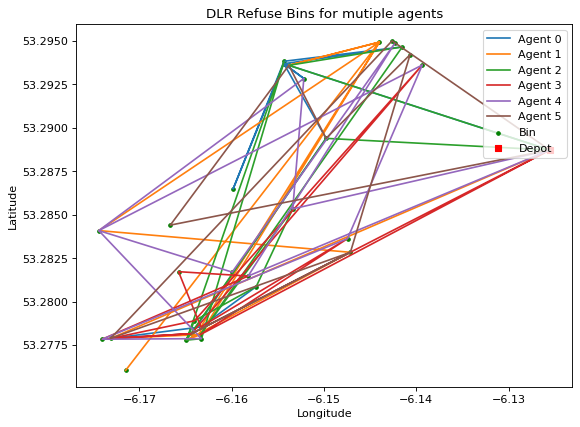

In [ ]:
makemap(d2)

In [ ]:
print(f"Minimum distance learnt by 6 Agents in a Multi-Agent Reinforcement learning environment is {min(mean_dist)} km ")

Minimum distance learnt by 2 Agents in a Multi-Agent Reinforcement learning environment is 12.554000000000002 km 


**8 Agents**

-------------0--------------
-------------1--------------
-------------2--------------
-------------3--------------
-------------4--------------
-------------5--------------
-------------6--------------
-------------7--------------
-------------8--------------
-------------9--------------
-------------10--------------
-------------11--------------
-------------12--------------
-------------13--------------
-------------14--------------
-------------15--------------
-------------16--------------
-------------17--------------
-------------18--------------
-------------19--------------
-------------20--------------
-------------21--------------
-------------22--------------
-------------23--------------
-------------24--------------
-------------25--------------
-------------26--------------
-------------27--------------
-------------28--------------
-------------29--------------
-------------30--------------
-------------31--------------
-------------32--------------
-------------33-----

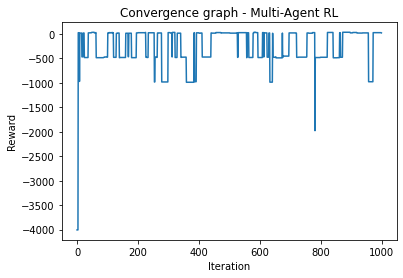

In [ ]:

if __name__ == "__main__":
    # episodes=100
    i=0
    for x in range(0, 8):
      globals()['Agent%s' % x] = AgentRL()
    # ag=AgentRL()
    
    Agent0.ResetParams()
    Agent1.ResetParams()
    Agent2.ResetParams()
    Agent3.ResetParams()
    Agent4.ResetParams()
    Agent5.ResetParams()
    Agent6.ResetParams()
    Agent7.ResetParams()
    env=Environment()
    IsEnd=False  

    epsilon=0.8
    
    FINAL_0={}
    FINAL_1={}
    FINAL_2={}
    FINAL_3={}
    FINAL_4={}
    FINAL_5={}
    FINAL_6={}
    FINAL_7={}
	
    DIST_TOTAL={}
    routelist={}
    routelist0={}
    routelist1={}
    routelist2={}
    routelist3={}
    routelist4={}
    routelist5={}
    routelist6={}
    routelist7={}

    routelist_len=[]
    dist0_cov=[]
    dist1_cov=[]
    dist2_cov=[]
    dist3_cov=[]
    dist4_cov=[]
    dist5_cov=[]
    dist6_cov=[]
    dist7_cov=[]    
	
    mean_dist=[]
    plot_reward=[]
    plot_reward2=[]
    while (i<episodes):
        epsilon = 0.95*epsilon
        print(f"-------------{i}--------------")
        
        env=Environment()
        Agent0.ResetParams()
        Agent1.ResetParams()
        Agent2.ResetParams()
        Agent3.ResetParams()
        Agent4.ResetParams()
        Agent5.ResetParams()
        Agent6.ResetParams()
        Agent7.ResetParams()
        
        env.weight=pd.Series(list(my_df['weight']))
        env.IsEnd=0  
        while (env.isEnd != -1):
            routelist0[i],dist0_covered=Agent0.Q_Learning(env,epsilon,0)
            routelist1[i],dist1_covered=Agent1.Q_Learning(env,epsilon,1)
            routelist2[i],dist2_covered=Agent2.Q_Learning(env,epsilon,2)
            routelist3[i],dist3_covered=Agent3.Q_Learning(env,epsilon,3)
            routelist4[i],dist4_covered=Agent4.Q_Learning(env,epsilon,4)
            routelist5[i],dist5_covered=Agent5.Q_Learning(env,epsilon,5)
            routelist6[i],dist6_covered=Agent6.Q_Learning(env,epsilon,6)
            routelist7[i],dist7_covered=Agent7.Q_Learning(env,epsilon,7)
        
        meandist=(dist0_covered+dist1_covered+dist2_covered+dist3_covered+dist4_covered+dist5_covered+dist6_covered+dist7_covered)/8
        dist0_cov.append(dist0_covered)
        dist1_cov.append(dist1_covered)
        dist2_cov.append(dist2_covered)
        dist3_cov.append(dist3_covered)
        dist4_cov.append(dist4_covered)
        dist5_cov.append(dist5_covered)
        dist6_cov.append(dist6_covered)
        dist7_cov.append(dist7_covered)
		
        mean_dist.append(meandist)
        routelist_len.append(len(routelist0[0]))
        i +=1
        plot_reward.append(Agent0.final_reward)
        plot_reward2.append(ag2.final_reward)
    min_route=routelist_len.index(min(routelist_len))
    min_route=dist0_cov.index(min(dist0_cov))
    routelist[0]=routelist0[min_route]
    routelist[1]=routelist1[min_route]
    routelist[2]=routelist2[min_route]
    routelist[3]=routelist3[min_route]
    routelist[4]=routelist4[min_route]
    routelist[5]=routelist5[min_route]
    routelist[6]=routelist6[min_route]
    routelist[7]=routelist7[min_route]
    # plt.plot(dist0_cov)
    # plt.plot(dist1_cov)
    #plt.plot(mean_dist)
    plt.title("Convergence graph - Multi-Agent RL")
    plt.xlabel("Iteration")
    plt.ylabel("Reward")
    

    plt.plot(plot_reward)  
    # plt.plot(plot_reward2)


Text(0, 0.5, 'Distance covered')

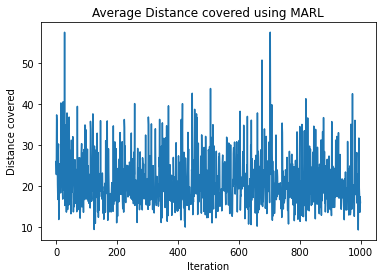

In [ ]:
plt.plot(mean_dist)
plt.title("Average Distance covered using MARL")
plt.xlabel("Iteration")
plt.ylabel("Distance covered")

In [ ]:
d2=prepPlot(routelist)
d2.keys()
# d3=prepPlot(routelist)
# d3.keys()

dict_keys(['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7'])

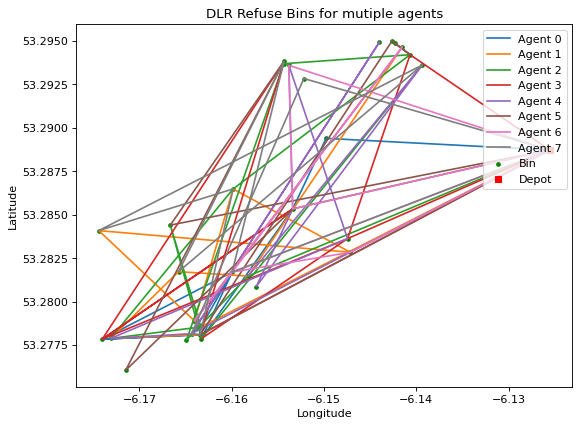

In [ ]:
makemap(d2)

In [ ]:
print(f"Minimum distance learnt by 8 Agents in a Multi-Agent Reinforcement learning environment is {min(mean_dist)} km ")

Minimum distance learnt by 2 Agents in a Multi-Agent Reinforcement learning environment is 9.402125 km 
